# Analyse du trafic cycliste à Paris en fonction de la météo

Ce mini-projet d'extraction et d'analyse de données autour du trafic cycliste à Paris a pour objectif :
- Comprendre et appliquer le concept d'ETL (Extract, Trasnform, Load)
- Explorer des données ouvertes (open data)
- Croiser deux sources de données (API + scraping)
- Stocker les données dans une base SQL (SQLite3)
- Réaliser une visualisation (Streamlit) et/ou un modèle simple

Précisions quant au concept d'ETL :
- **Extract**: récupérer des données depuis une source (API, fichier, web...)
- **Transform**: nettoyer, reformater, enrichir les données
- **Load**: stocker les données dans une format structuré (CSV, DB, ...)

On souhaite répondre à la problématique suivante :

**Comment la météo influence-t-elle l'utilisation des pistes cyclables à Paris ?**

---

## Libraries

In [1]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import  datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from meteocielprocessor import MeteocielProcessor

## Extraction des données
Sources :

- [Données météo station Tour Eiffel](https://www.meteociel.fr/climatologie/obs_villes.php)
- [Données compteurs de vélos pour le site de comptage nommé 36 quai de Grenelle](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/api/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name)


### Scraping Meteociel

In [177]:
meteociel_processor = MeteocielProcessor()
start_date = datetime.date(year=2024, month=1, day=1)
end_date = datetime.date(year=2025, month=12, day=1)

df_meteociel = meteociel_processor.get_daily_data_from_period(start_date.month, start_date.year, end_date.month, end_date.year)
df_meteociel.head()

,temp_max,temp_min
date,,
2024-01-01,9.6,4.9
2024-01-02,10.7,7.4
2024-01-03,10.3,8.4
2024-01-04,9.6,6.2
2024-01-05,6.8,4.4


### API Open Data

In [169]:
def update_cyclist_data(data, offset):
    url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/comptage-velo-donnees-compteurs/records"
    params = {
        "select": ["sum_counts","date"],
        "limit": 100,
        "offset": offset,
        "refine": ['nom_compteur:36 quai de Grenelle NE-SO']
        }
    response = json.loads(
        requests.get(url, params).content
        )
    
    data["date"] = data["date"] + [dic['date'] for dic in response["results"]]
    data["sum_count"] = data["sum_count"] + [dic['sum_counts'] for dic in response["results"]]

def get_total_count():
    url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/comptage-velo-donnees-compteurs/records"
    offset = 0
    params = {
        "select": ["sum_counts","date"],
        "limit": 0,
        "offset": offset,
        "refine": ['nom_compteur:36 quai de Grenelle NE-SO']
        }
    response = json.loads(
        requests.get(url, params).content
        )
    return response['total_count']

In [170]:
data = {
    "date": [],
    "sum_count": []
    }
offset = 0
while offset <= get_total_count():
    update_cyclist_data(data, offset)
    offset += 100

In [174]:
df_cyclist = pd.DataFrame(data)
df_cyclist["date"] = pd.to_datetime(df_cyclist["date"])
df_cyclist = df_cyclist.set_index("date")

## Transformation des données

Les données de comptage de vélo sont échantillonnées plusieurs fois par jour, là où les données de températures sont quotidiennes.
- Nous commençons donc par récupérer le compte journalier de vélo avec un `groupby().sum()`
- Avant de pouvoir `join` les deux tables.

In [175]:
df_cyclist = df_cyclist.groupby(df_cyclist.index.date).sum()
df_cyclist.index = df_cyclist.index.rename("date")
df_cyclist.head()

,sum_count
date,
2024-11-01,1389
2024-11-02,1601
2024-11-03,1409
2024-11-04,2947
2024-11-05,3125


In [178]:
df = df_cyclist.join(df_meteociel, how='left')
df.head()

,sum_count,temp_max,temp_min
date,,,
2024-11-01,1389,10.3,7.1
2024-11-02,1601,9.8,7.6
2024-11-03,1409,8.5,7.1
2024-11-04,2947,12.7,6.6
2024-11-05,3125,11.7,6.4


## Stockage des données 
D'abord en `CSV`.

In [179]:
# En CSV
df_meteociel.to_csv("../data/daily-temperatures-2024-2025.csv")
df_cyclist.to_csv("../data/cyclists-2024-2025.csv")
df.to_csv("../data/cyclist-temp-2024-2025.csv")

Puis dans une base de données `SQLite`

In [22]:
engine = create_engine('sqlite:///../db/cyclist-temp.db', echo=True)
sqlite_connection = engine.connect()

In [23]:
df.to_sql(name="cyclist-temp", con=sqlite_connection)

2025-12-23 12:01:10,979 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-12-23 12:01:10,982 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("cyclist-temp")
2025-12-23 12:01:10,982 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-12-23 12:01:10,984 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("cyclist-temp")
2025-12-23 12:01:10,985 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-12-23 12:01:10,987 INFO sqlalchemy.engine.Engine 
CREATE TABLE "cyclist-temp" (
	"index" DATETIME, 
	sum_count BIGINT, 
	temp_max FLOAT, 
	temp_min FLOAT
)


2025-12-23 12:01:10,988 INFO sqlalchemy.engine.Engine [no key 0.00066s] ()
2025-12-23 12:01:10,991 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_cyclist-temp_index" ON "cyclist-temp" ("index")
2025-12-23 12:01:10,992 INFO sqlalchemy.engine.Engine [no key 0.00059s] ()
2025-12-23 12:01:11,003 INFO sqlalchemy.engine.Engine INSERT INTO "cyclist-temp" ("index", sum_count, temp_max, temp_min) VALUES (?, ?, ?, ?)
2025-12-23 12:01:11,004 INFO sqlalc

417

In [24]:
sqlite_connection.close()

## Visualisation des données

On observe une corrélation positive entre le nombre de le vélos comptés et la température. 

In [269]:
df = pd.read_csv("../data/cyclist-temp-2024-2025.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

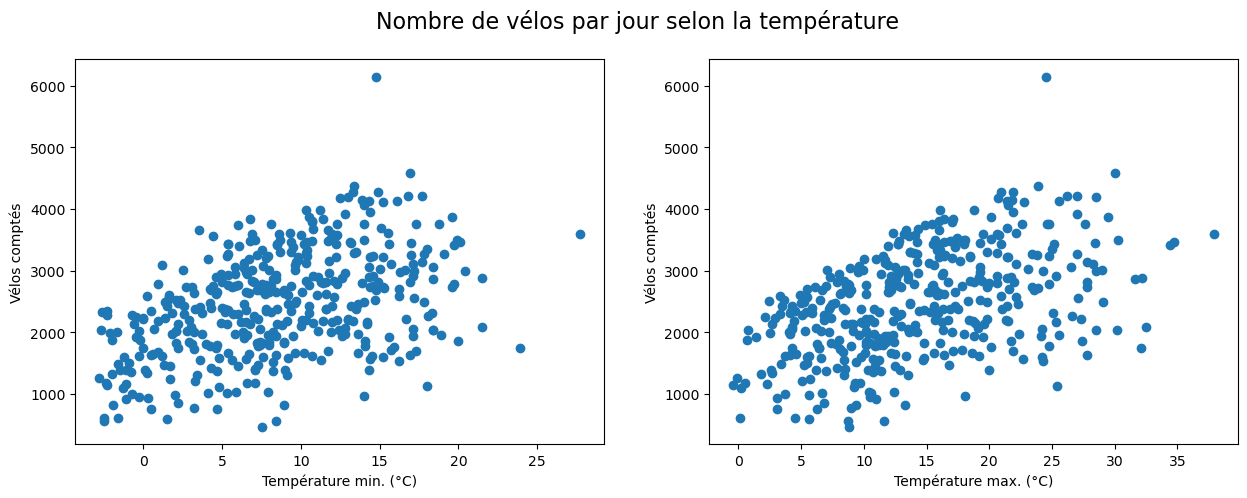

In [270]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
axes[0].scatter(df["temp_min"], df["sum_count"])
axes[0].set_xlabel("Température min. (°C)")
axes[0].set_ylabel("Vélos comptés")
axes[1].scatter(df["temp_max"], df["sum_count"])
axes[1].set_xlabel("Température max. (°C)")
axes[1].set_ylabel("Vélos comptés")
fig.suptitle("Nombre de vélos par jour selon la température", fontsize=16, horizontalalignment='center')
plt.show()

## Modèles prédictifs

Pour qu'un modèle soit performant, il serait sans doute judicieux de considérer les données comme une série temporelle de sorte à prendre en compte la périodicité des données (week-end, vacances, etc.), ou à minima ajouter des features telles que le mois de l'année, ou les précipitations. Cependant, pour cet exercice, limitons nous à un modèle simple ne prenant en compte que la température. On remarque de la visualisation ci-dessus qu'une simple régression linéaire devrait suffir.

Par ailleurs, la température min. et max. sont deux features extrêment corrélées (cf figure ci-dessous), il est donc préférable de construire le modèle en n'utilisant qu'une de ces deux données. Choisissons arbitrairement la température maximale ici.

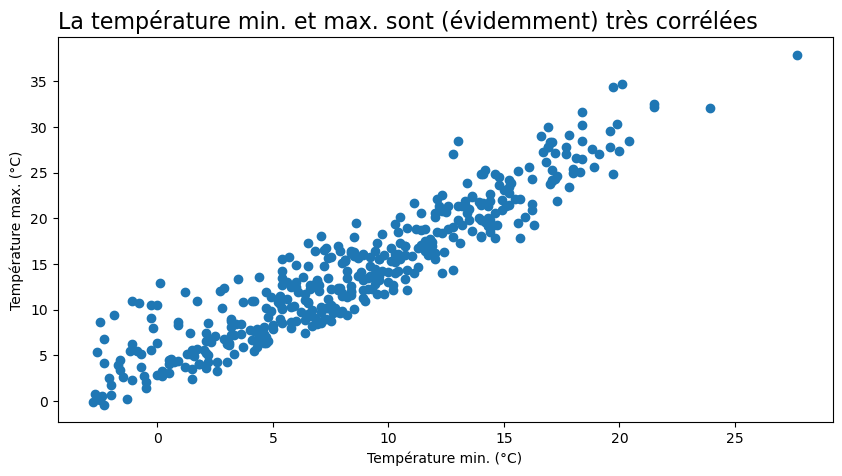

In [271]:
plt.figure(figsize=(10,5))
plt.scatter(df["temp_min"], df["temp_max"])
plt.xlabel("Température min. (°C)")
plt.ylabel("Température max. (°C)")
plt.title("La température min. et max. sont (évidemment) très corrélées", fontsize=16, loc='left')
plt.show()

### Premier modèle : régression linéaire sur la température max.

#### Entrainement

In [272]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import numpy as np

In [280]:
# Train test split
X = df[["temp_max"]]
y = df["sum_count"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Performances

In [282]:
# Dummy regressor
dummy = DummyRegressor(strategy="mean")

# Model
model = LinearRegression()

In [283]:
# Train models
dummy.fit(X_train, y_train)
model.fit(X_train, y_train)

# Predict
y_pred_dummy = dummy.predict(X_test)
y_pred = model.predict(X_test)

In [284]:
# Performance
rmse = root_mean_squared_error(y_test, y_pred)
rmse_dummy = root_mean_squared_error(y_test, y_pred_dummy)
print(
    f"Dummy RMSE: {rmse_dummy:.0f}\n"
    f"Model RMSE: {rmse:.0f}"
)

Dummy RMSE: 866
Model RMSE: 779


In [285]:
X_train_unscaled = scaler.inverse_transform(X_train)
X_test_unscaled = scaler.inverse_transform(X_test)

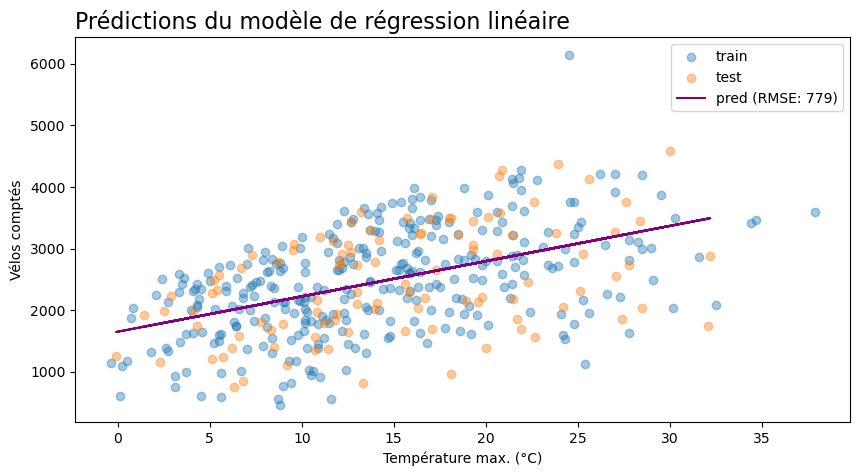

In [286]:
fig, axes = plt.subplots(1,1,figsize=(10, 5))

axes.scatter(X_train_unscaled, y_train, label="train", alpha=0.4)
axes.scatter(X_test_unscaled, y_test, label="test", alpha=0.4)
axes.plot(X_test_unscaled, y_pred, label=f"pred (RMSE: {rmse:.0f})", color="purple")
axes.legend()
axes.set_xlabel("Température max. (°C)")
axes.set_ylabel("Vélos comptés")
axes.set_title("Prédictions du modèle de régression linéaire", fontsize=16, loc="left")
plt.show()

### Amélioration du modèle : prise en compte du jour de la semaine

On intuite une périodicité semaine/week-end. Sans pour autant se lancer dans un modèle de série temporelle type SARIMA, incluons le jour de la semaine dans les features prédictives.

#### Entrainement

In [287]:
df["dayofweek"] = df.index.dayofweek
df.head()

,sum_count,temp_max,temp_min,dayofweek
date,,,,
2024-11-01,1389,10.3,7.1,4
2024-11-02,1601,9.8,7.6,5
2024-11-03,1409,8.5,7.1,6
2024-11-04,2947,12.7,6.6,0
2024-11-05,3125,11.7,6.4,1


In [288]:
# Train test split
X = df[["temp_max", "dayofweek"]]
y = df["sum_count"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37)

In [289]:
# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([('scaler', StandardScaler())])
cat_pipeline = Pipeline([('encoder', OneHotEncoder())])
preprocessor = ColumnTransformer([
    ('num', num_pipeline, ["temp_max"]),
    ('cat', cat_pipeline, ['dayofweek'])
])

In [290]:
# Dummy regressor
dummy = Pipeline([
    ('preprocessing', preprocessor),
    ('dummy',DummyRegressor(strategy="mean"))
])

# Model
model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

# Train models
dummy.fit(X_train, y_train)
model.fit(X_train, y_train)

# Predict
y_pred_dummy = dummy.predict(X_test)
y_pred2 = model.predict(X_test)

#### Performances

In [295]:
# Performance
rmse2 = root_mean_squared_error(y_test, y_pred2)
rmse_dummy = root_mean_squared_error(y_test, y_pred_dummy)
print(
    f"Dummy RMSE: {rmse_dummy:.0f}\n"
    f"Model RMSE: {rmse2:.0f}"
)

Dummy RMSE: 866
Model RMSE: 612


### Synthèse

Bien que significativement meilleures que le Dummy Regressor, les performances des modèles restent médiocres. La température et le jour de la semaine ne suffisent pas à prédire précisemment le nombre de cyclistes sur les pistes. 

Ceci étant dit, le modèle pourrait sans doute être amélioré. On remarque notamment que les erreurs de prédiction ne sont pas centrée sur 0 pour les hautes et basses valeurs, ce qui suggère qu'elle ne sont pas seulement résiduelles, mais contiennent encore de l'information qui pourraient être extraites par notre modèle si on lui en donnait les clefs. On anticipe intuitivement que les précipitations doivent significativement influer le choix de mobilité. Par ailleurs, on pourrait éventuellement considérer un modèle non linéaire, en imaginant, par exemple, qu'à partir d'une température seuille, la chaleur devient un facteur limitant le nombre de cyclistes.

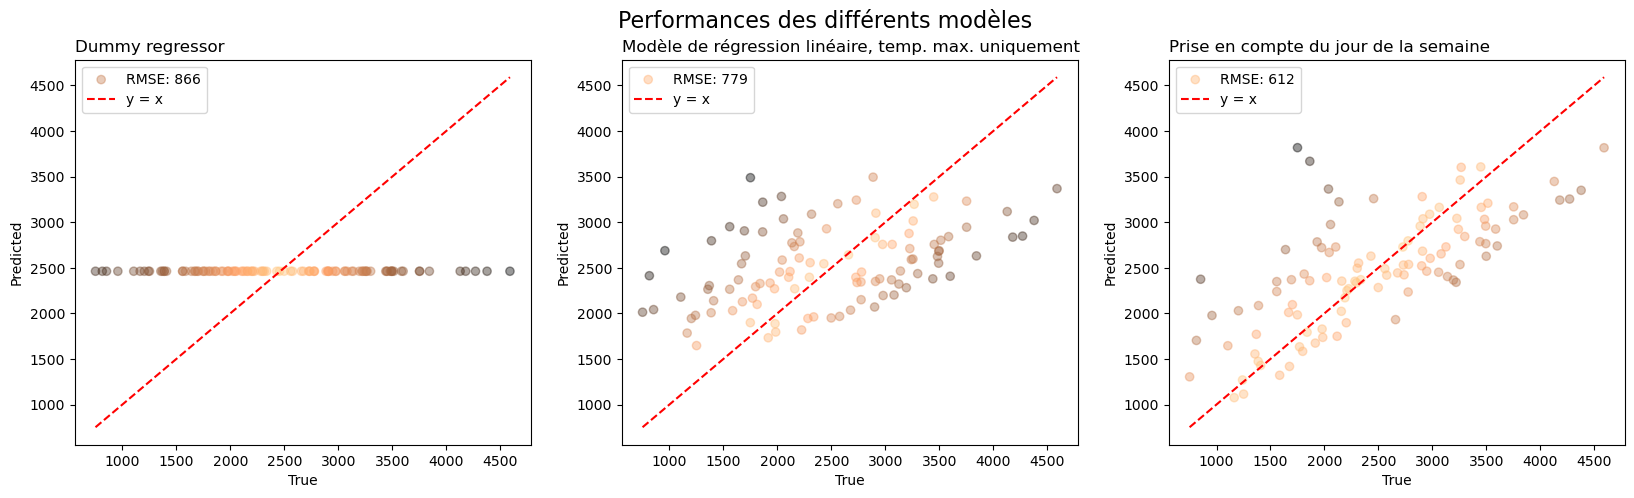

In [307]:
fig, axes = plt.subplots(1,3,figsize=(20, 5))
my_cmap = plt.get_cmap("copper_r")

# Subplot 1
axes[0].scatter(y_test, y_pred_dummy, c=np.abs(y_pred_dummy - y_test), cmap=my_cmap, label=f"RMSE: {rmse_dummy:.0f}", alpha=0.4)
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="y = x",)
axes[0].legend()
axes[0].set_xlabel("True")
axes[0].set_ylabel("Predicted")
axes[0].set_title("Dummy regressor", loc="left")

# Subplot 2
axes[1].scatter(y_test, y_pred, c=np.abs(y_pred - y_test), cmap=my_cmap, label=f"RMSE: {rmse:.0f}", alpha=0.4)
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="y = x",)
axes[1].legend()
axes[1].set_xlabel("True")
axes[1].set_ylabel("Predicted")
axes[1].set_title("Modèle de régression linéaire, temp. max. uniquement", loc="left")

# Subplot 3
axes[2].scatter(y_test, y_pred2, c=np.abs(y_pred2 - y_test), cmap=my_cmap, label=f"RMSE: {rmse2:.0f}", alpha=0.4)
axes[2].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="y = x",)
axes[2].legend()
axes[2].set_xlabel("True")
axes[2].set_ylabel("Predicted")
axes[2].set_title("Prise en compte du jour de la semaine", loc="left")

fig.suptitle("Performances des différents modèles", fontsize=16)
plt.show()

In [330]:
print(
    "SYNTHESE RMSE\n"
    f"{"Dummy ":.<15} {rmse_dummy:.0f}\n"
    f"{"Model 1 ":.<15} {rmse:.0f}\n"
    f"{"Model 2 ":.<15} {rmse2:.0f}"
)

SYNTHESE RMSE
Dummy ......... 866
Model 1 ....... 779
Model 2 ....... 612
